--- Selected Dataset: AWEKAS (Raw) ---
Path: D:\Development\RESEARCH\neve_ilan_station\AWEKAS\Neve_Ilan_AWEKAS_20251026_20251207.csv
Data Loaded Successfully.
Time Range: 2025-10-27 00:00:00 to 2025-12-07 14:00:00
Total Records: 999
------------------------------
Generating Synoptic Overview Plot...


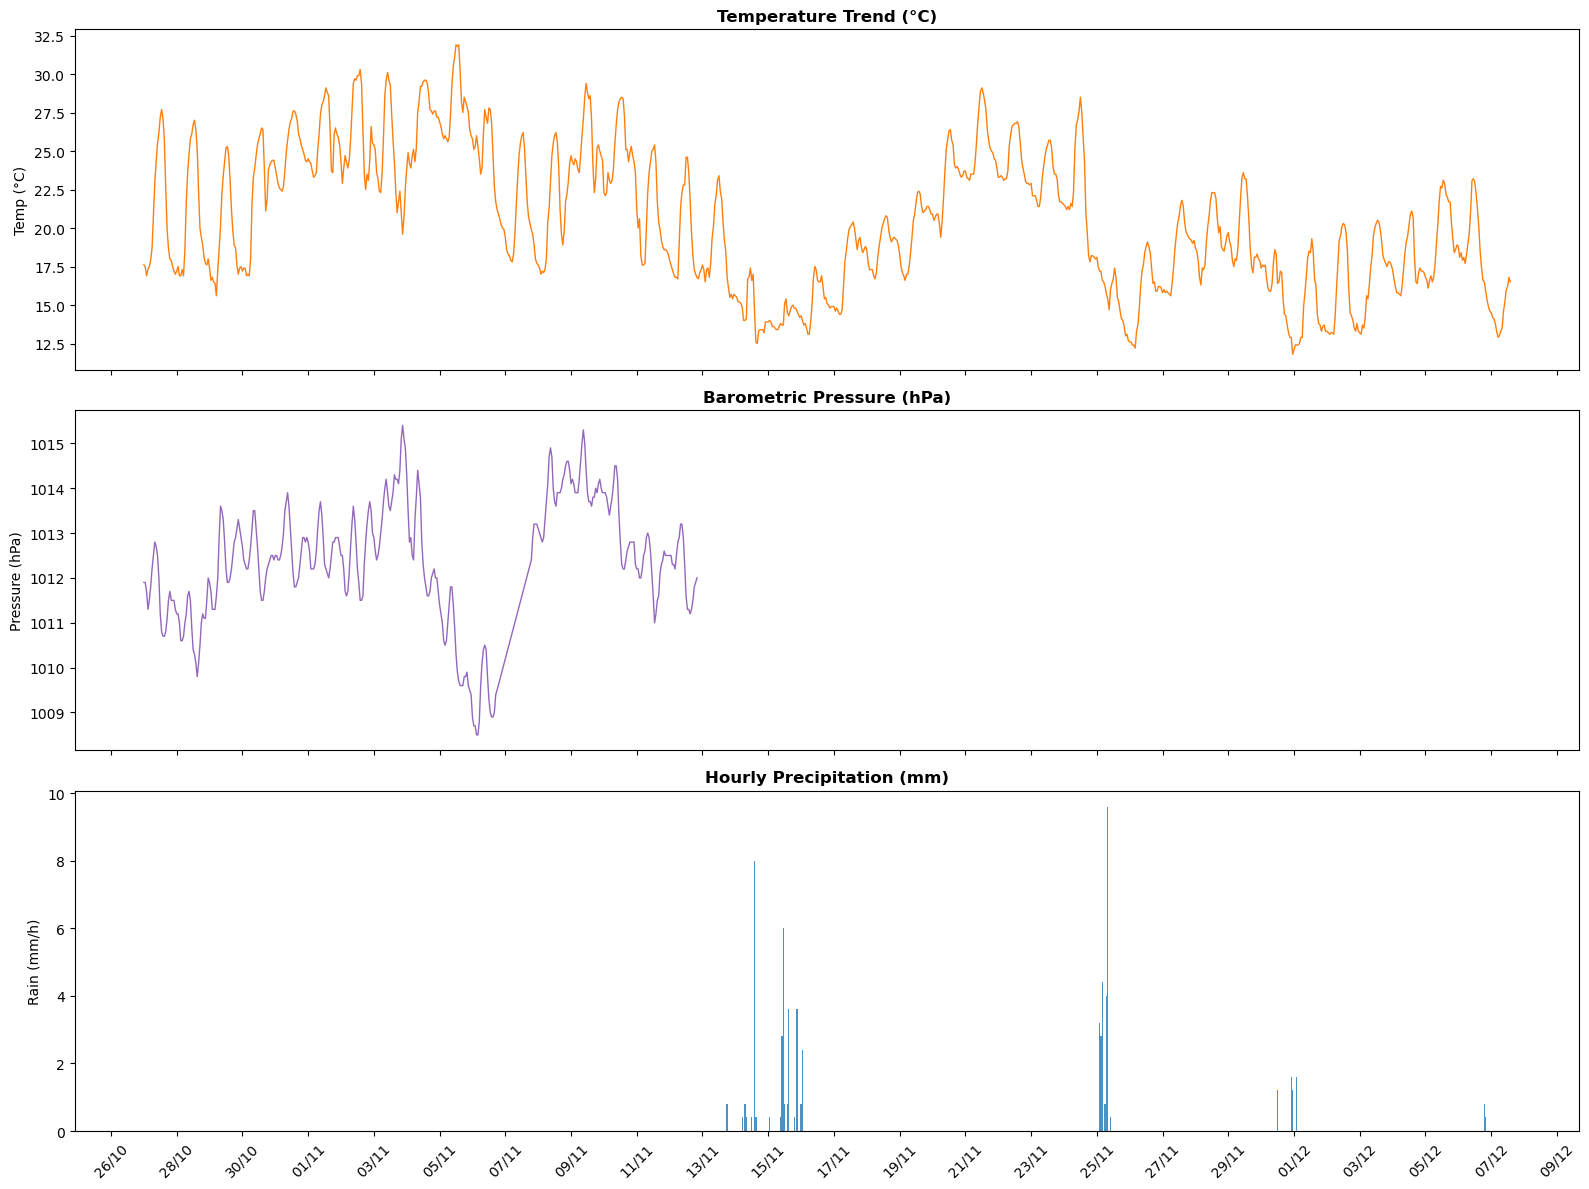

Generating Hydrological Analysis...


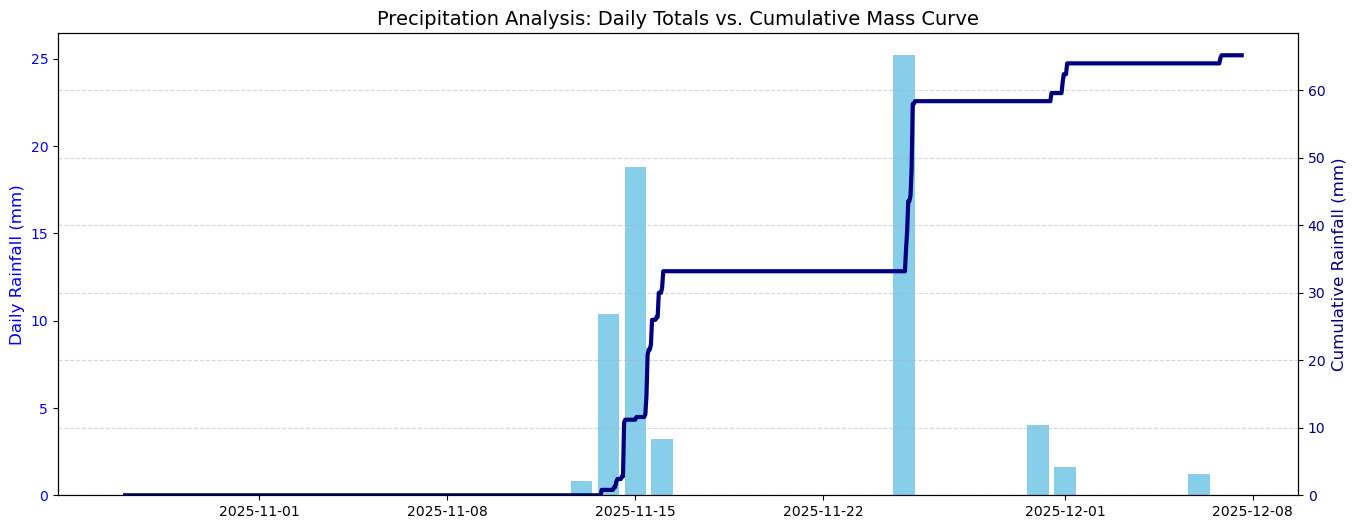


--- 🌧️ Hydrological Summary ---
Total Rainfall: 65.20 mm
Wettest Day: 25/11/2025 (25.20 mm)
Max 5-min Intensity: 9.60 mm (Recorded at 2025-11-25 08:00:00)
------------------------------
Generating Correlation Matrix...


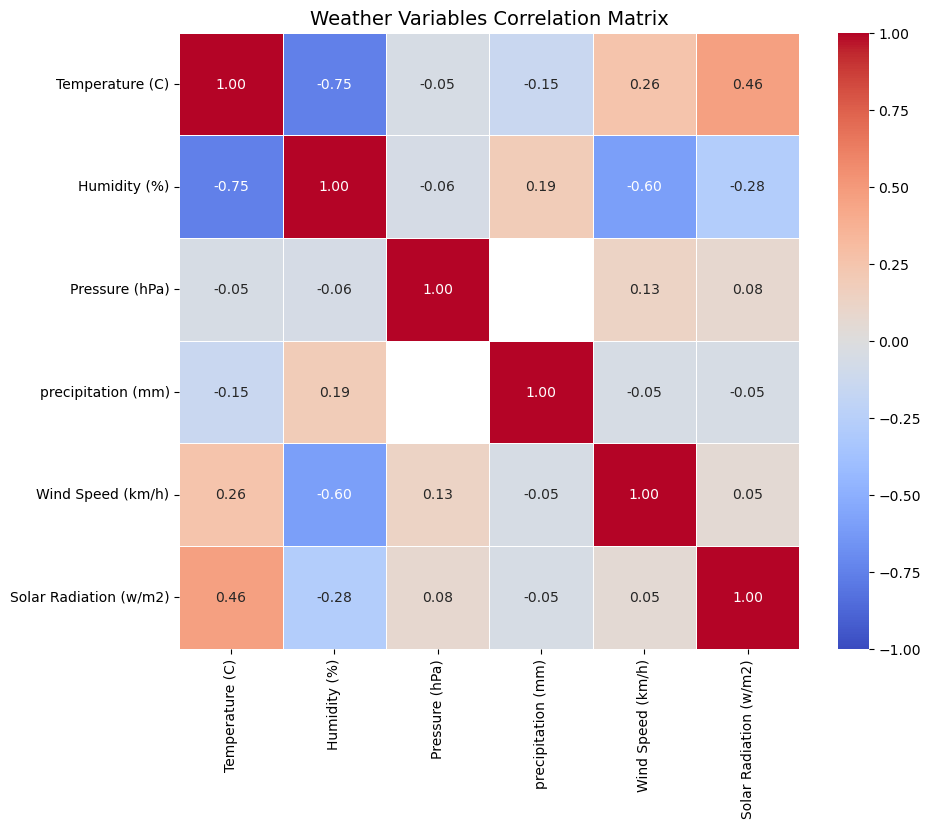

Generating Diurnal Cycle Plot...


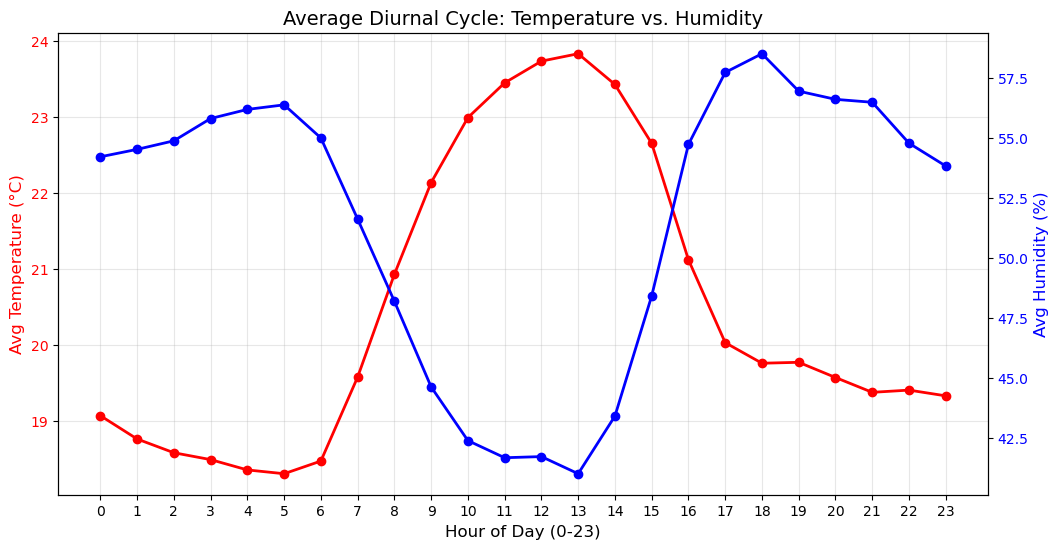

--- Analysis Complete ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

# --- 1. CONFIGURATION: DATASET SELECTION ---

# Define the paths to your 3 datasets
# MAKE SURE the filenames for 1 and 2 match exactly what you have on your disk!
base_dir = r"D:\Development\RESEARCH\neve_ilan_station"

datasets = {
    1: "WUG (Raw)",       # Name for display
    2: "AWEKAS (Raw)",    
    3: "Unified (Final)"  
}

paths = {
    1: os.path.join(base_dir, "WUG", "Neve_Ilan_WUG_20251026_20251207.csv"),     # <--- Update filename if needed
    2: os.path.join(base_dir, "AWEKAS", "Neve_Ilan_AWEKAS_20251026_20251207.csv"), # <--- Update filename if needed
    3: os.path.join(base_dir, "Unified_Complete_Weather.csv")
}

# ==========================================
# 👉 CHOOSE YOUR DATASET HERE (1, 2, or 3)
SELECTION = 2
# ==========================================

file_path = paths.get(SELECTION)
dataset_name = datasets.get(SELECTION)

print(f"--- Selected Dataset: {dataset_name} ---")
print(f"Path: {file_path}")

if not os.path.exists(file_path):
    print(f"❌ CRITICAL ERROR: File not found!\nCheck the path: {file_path}")
    # Stop execution if file missing
    raise FileNotFoundError("Selected file does not exist.")

# --- 2. DATA LOADING ... (Continue with the rest of the code) ---
# ...

# --- 2. DATA LOADING & PREPROCESSING ---
try:
    df = pd.read_csv(file_path)
    
    # Create Datetime Index
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('Datetime', inplace=True)
    
    # Drop redundant columns
    df.drop(columns=['Date', 'Time'], inplace=True, errors='ignore')
    
    # Ensure all analysis columns are numeric
    numeric_cols = ['Temperature (C)', 'Humidity (%)', 'Pressure (hPa)', 
                    'precipitation (mm)', 'Wind Speed (km/h)', 'Solar Radiation (w/m2)']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    print(f"Data Loaded Successfully.")
    print(f"Time Range: {df.index.min()} to {df.index.max()}")
    print(f"Total Records: {len(df)}")
    print("-" * 30)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()

# --- 3. VISUALIZATION: SYNOPTIC OVERVIEW (Temp, Pressure, Rain) ---
print("Generating Synoptic Overview Plot...")
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Plot A: Temperature
sns.lineplot(data=df, x=df.index, y='Temperature (C)', ax=axes[0], color='#ff7f0e', linewidth=1)
axes[0].set_title('Temperature Trend (°C)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temp (°C)')

# Plot B: Pressure (good for identifying storm systems)
sns.lineplot(data=df, x=df.index, y='Pressure (hPa)', ax=axes[1], color='#9467bd', linewidth=1)
axes[1].set_title('Barometric Pressure (hPa)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pressure (hPa)')

# Plot C: Precipitation (Hourly Sum for better visualization)
hourly_rain = df['precipitation (mm)'].resample('H').sum()
axes[2].bar(hourly_rain.index, hourly_rain.values, width=0.04, color='#1f77b4', alpha=0.8)
axes[2].set_title('Hourly Precipitation (mm)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Rain (mm/h)')

# Format X-Axis dates
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axes[2].xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 4. HYDROLOGICAL ANALYSIS (Daily & Cumulative) ---
print("Generating Hydrological Analysis...")

# Calculate Daily Stats
daily_stats = df.resample('D').agg({
    'precipitation (mm)': 'sum',
    'Temperature (C)': ['max', 'min', 'mean']
})
daily_stats.columns = ['Rain_Total', 'Temp_Max', 'Temp_Min', 'Temp_Avg']

# Calculate Cumulative Rain (Mass Curve)
df['Rain_Cumulative'] = df['precipitation (mm)'].cumsum()

# Plot Daily vs Cumulative
fig, ax1 = plt.subplots(figsize=(16, 6))

# Bar Chart (Daily)
ax1.bar(daily_stats.index, daily_stats['Rain_Total'], color='skyblue', label='Daily Rain', width=0.8)
ax1.set_ylabel('Daily Rainfall (mm)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(False) # Turn off grid for cleaner look with bars
ax1.set_ylim(0)

# Line Chart (Cumulative)
ax2 = ax1.twinx()
ax2.plot(df.index, df['Rain_Cumulative'], color='navy', linewidth=3, label='Cumulative Rain')
ax2.set_ylabel('Cumulative Rainfall (mm)', color='navy', fontsize=12)
ax2.tick_params(axis='y', labelcolor='navy')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_ylim(0)

plt.title('Precipitation Analysis: Daily Totals vs. Cumulative Mass Curve', fontsize=14)
plt.show()

# Print Key Hydrological Stats
total_rain = df['precipitation (mm)'].sum()
max_intensity_5min = df['precipitation (mm)'].max()
time_max_intensity = df['precipitation (mm)'].idxmax()
wettest_day_val = daily_stats['Rain_Total'].max()
wettest_day_date = daily_stats['Rain_Total'].idxmax()

print(f"\n--- 🌧️ Hydrological Summary ---")
print(f"Total Rainfall: {total_rain:.2f} mm")
print(f"Wettest Day: {wettest_day_date.strftime('%d/%m/%Y')} ({wettest_day_val:.2f} mm)")
print(f"Max 5-min Intensity: {max_intensity_5min:.2f} mm (Recorded at {time_max_intensity})")
print("-" * 30)

# --- 5. CORRELATION MATRIX ---
print("Generating Correlation Matrix...")
corr_cols = ['Temperature (C)', 'Humidity (%)', 'Pressure (hPa)', 
             'precipitation (mm)', 'Wind Speed (km/h)', 'Solar Radiation (w/m2)']

# Filter only existing columns
existing_cols = [c for c in corr_cols if c in df.columns]
corr_matrix = df[existing_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Weather Variables Correlation Matrix', fontsize=14)
plt.show()

# --- 6. DIURNAL CYCLE (Average Day) ---
print("Generating Diurnal Cycle Plot...")
hourly_avg = df.groupby(df.index.hour).mean(numeric_only=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Temp
ax1.plot(hourly_avg.index, hourly_avg['Temperature (C)'], 'r-o', linewidth=2, label='Temperature')
ax1.set_xlabel('Hour of Day (0-23)', fontsize=12)
ax1.set_ylabel('Avg Temperature (°C)', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3)

# Humidity
ax2 = ax1.twinx()
ax2.plot(hourly_avg.index, hourly_avg['Humidity (%)'], 'b-o', linewidth=2, label='Humidity')
ax2.set_ylabel('Avg Humidity (%)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Average Diurnal Cycle: Temperature vs. Humidity', fontsize=14)
plt.show()

print("--- Analysis Complete ---")